<a href="https://colab.research.google.com/github/AR615598/Classifying_Cancer_Cells/blob/main/cancer_cell_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
# Author: Alexander Ramirez, Christine Wang, Jiaxi Tang

# General Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML Libraries
import torch 
import keras
import sklearn
from sklearn.decomposition import PCA
import tensorflow

In [74]:
# Loading CSV
csv = 'https://raw.githubusercontent.com/AR615598/Classifying_Cancer_Cells/main/Cancer_Data.csv'
# save as Pandas dataframe
cc = pd.read_csv(csv)

To Do 


1.   Data Exploration, linearity etc 
3.   Clean the data
4.   Preprocess the data, like normalizing, standardize 



<h2> Identifying and Distinguishing Between Benign and Malignant Cells </h2>
It is a common misconception that everyone has cancerous cells in their body, the reality is that our bodies are constantly producing cells that have the potential to become cancerous. Cancerous cells exhibit different behavior than normal cells, as they do not adhere to the same protocols and persistently reproduce without undergoing routine cell death. This unchecked growth leads to the development of cancerous tumors, and the spread of cancerous cells through the body. It is noteworthy that the body does not always recognize cancerous cells as foreign, and in fact, sometimes is self-sabatoges itself by supporting their growth by providing means of acheing growth throught things liek blood lines. Consequently, tumors represent the manifestation of cancer.

While it's natural to feel frightened about cancer, it's important to understand the differences between benign and malignant cells. Although benign cells are noncancerous, they can still exhibit abnormal cell growth and form tumors. The crucial difference is that benign cells cannot invade other tissues, which means they are typically not life-threatening. However, they should still be monitored because they can displace other organs. For example, a brain tumor can put pressure on sensitive areas of the brain.

On the other hand, malignant cells are typically more life-threatening because they can invade other tissues. This allows them to spread to other organs and potentially cause organ failure. The systems that allow cells to function normally are very specialized, and the invasion of malignant cells disrupts this delicate balance and causes damage. As a result, it's crucial to identify malignant cells as early as possible and take appropriate steps to prevent their spread.

Another crucial factor to consider when distinguishing between benign and malignant cells is the difference in treatment options. Benign tumors are typically treated through surgical removal, and once removed, they are unlikely to regrow as long as all the abnormal cells have been removed.

In contrast, malignant tumors can spread to other parts of the body and require more aggressive treatments, such as chemotherapy, radiation therapy, or targeted therapy, to eradicate cancerous cells throughout the body. In some cases, surgery may also be necessary to remove the primary tumor, as well as any other tumors that have developed as a result of the cancer spreading. Because of the potential for malignant cells to spread, it's important to diagnose and treat them as early as possible to increase the chances of successful treatment.
This is wny identifying cancerous cells and classifying them is so important, being able to identify benign cells allows doctors to plan accordingly with alot of information, malignant cells on the other hand are much more difficult to treat and makes treatment more difficult, but being able to identify them early will lead to drastically better outcomes. 

<h2>About the Dataset</h2>

The dataset is a comprehensive collection of information about cancer cells, providing nearly 600 examples for analysis. Each example in the dataset is characterized by 32 columns, with 30 of them being used to describe the visual characteristics of the cell. These visual characteristics provide important information about the cancer cell, including its radius, texture, perimeter, area, smoothness, compactness, concavity, and concave points.

The last two columns in the dataset are the example ID and the label. The example ID is a unique identifier for each example, which can be used to keep track of specific instances within the dataset. The label column indicates whether the cell is classified as malignant or benign.



In [75]:
# drop not needed columns
cc = cc.drop(labels="id", axis=1)

In [76]:
# One hot encoding labels
cc = pd.get_dummies(cc, columns=['diagnosis'])
cc = cc.rename(columns={'diagnosis_B': 'Benign', 'diagnosis_M': 'Malignant'})

In [77]:
cc['Benign'].value_counts()

1    357
0    212
Name: Benign, dtype: int64

In [78]:
null_cols = cc.columns[cc.isnull().any()]
if len(null_cols) == 0:
  print("No null values")
else:
  for cols in null_cols:
    print(cols)

No null values


No Null values. Great! We don't need to process non-null entries.

# Data Exploration

First, we would like to examine the relationship between benign / malignant and all other features. We would also like to see the correlation between variables for easy dimension reduction.

In [79]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

In [80]:
# only interested in the covariance between beningn / malgnant and other variables 
cov_mat = np.cov(cc,rowvar=False)[-2:]
print(cov_mat)

[[-1.24495449e+00 -8.64145276e-01 -8.73243824e+00 -1.20738222e+02
  -2.44031758e-03 -1.52456362e-02 -2.68640582e-02 -1.45827836e-02
  -4.38448074e-03  4.38614198e-05 -7.61074368e-02  2.21659602e-03
  -5.44134584e-01 -1.20688191e+01  9.73724102e-05 -2.53915769e-03
  -3.70637700e-03 -1.21837841e-03  2.60886253e-05 -9.98422189e-05
  -1.81604183e+00 -1.35895895e+00 -1.27308678e+01 -2.02184994e+02
  -4.65677477e-03 -4.49973956e-02 -6.65922914e-02 -2.52425892e-02
  -1.24633432e-02 -2.83069850e-03  2.34176589e-01 -2.34176589e-01]
 [ 1.24495449e+00  8.64145276e-01  8.73243824e+00  1.20738222e+02
   2.44031758e-03  1.52456362e-02  2.68640582e-02  1.45827836e-02
   4.38448074e-03 -4.38614198e-05  7.61074368e-02 -2.21659602e-03
   5.44134584e-01  1.20688191e+01 -9.73724102e-05  2.53915769e-03
   3.70637700e-03  1.21837841e-03 -2.60886253e-05  9.98422189e-05
   1.81604183e+00  1.35895895e+00  1.27308678e+01  2.02184994e+02
   4.65677477e-03  4.49973956e-02  6.65922914e-02  2.52425892e-02
   1.2463

In [81]:
len(cov_mat[0]) == len(cc.columns[1:])

False

In [82]:
# benign features
blist = list(zip(cov_mat[0],cc.columns[1:]))
blist

[(-1.2449544914478086, 'texture_mean'),
 (-0.8641452758731648, 'perimeter_mean'),
 (-8.732438241045571, 'area_mean'),
 (-120.73822186192729, 'smoothness_mean'),
 (-0.002440317582118369, 'compactness_mean'),
 (-0.015245636185301616, 'concavity_mean'),
 (-0.026864058180895566, 'concave points_mean'),
 (-0.01458278358375208, 'symmetry_mean'),
 (-0.004384480742097575, 'fractal_dimension_mean'),
 (4.386141983712459e-05, 'radius_se'),
 (-0.07610743675586025, 'texture_se'),
 (0.0022165960172281533, 'perimeter_se'),
 (-0.5441345843956534, 'area_se'),
 (-12.06881907349192, 'smoothness_se'),
 (9.737241020817353e-05, 'compactness_se'),
 (-0.002539157686452636, 'concavity_se'),
 (-0.0037063769981930256, 'concave points_se'),
 (-0.001218378412832001, 'symmetry_se'),
 (2.6088625337260897e-05, 'fractal_dimension_se'),
 (-9.98422188668036e-05, 'radius_worst'),
 (-1.816041832718632, 'texture_worst'),
 (-1.3589589470036385, 'perimeter_worst'),
 (-12.730867812322089, 'area_worst'),
 (-202.18499436867262,

In [83]:
top_5_ben = sorted(blist, key=lambda x : x[0])[:8]
bottom_5_ben = sorted(blist, key=lambda x : x[0])[-8:]

print("Weakest linear indicators of Benign:")
for elt,col in top_5_ben:
    print(f"cov: {elt},\t Column: {col}")
    
print("\nStrongest linear indicators of Benign:")
for elt,col in bottom_5_ben[::-1]:
    print(f"cov: {elt},\t Column: {col}")

Weakest linear indicators of Benign:
cov: -202.18499436867262,	 Column: smoothness_worst
cov: -120.73822186192729,	 Column: smoothness_mean
cov: -12.730867812322089,	 Column: area_worst
cov: -12.06881907349192,	 Column: smoothness_se
cov: -8.732438241045571,	 Column: area_mean
cov: -1.816041832718632,	 Column: texture_worst
cov: -1.3589589470036385,	 Column: perimeter_worst
cov: -1.2449544914478086,	 Column: texture_mean

Strongest linear indicators of Benign:
cov: 0.2341765885294197,	 Column: Malignant
cov: 0.0022165960172281533,	 Column: perimeter_se
cov: 9.737241020817353e-05,	 Column: compactness_se
cov: 4.386141983712459e-05,	 Column: radius_se
cov: 2.6088625337260897e-05,	 Column: fractal_dimension_se
cov: -9.98422188668036e-05,	 Column: radius_worst
cov: -0.001218378412832001,	 Column: symmetry_se
cov: -0.002440317582118369,	 Column: compactness_mean


From the above ranking, we can see that the following are the weakest linear indicators of Benign:
* smoothness_worst
* smoothness_mean
* area_worst
* smoothness_se
* area_mean

The following are the strongest linear indicators of Benign:

* perimeter_se
* compactness_se
* radius_se
* fractal_dimension_se





In [84]:
# malignant features
mlist = list(zip(cov_mat[1],cc.columns[1:]))

In [85]:

top_5_mal = sorted(mlist, key=lambda x : x[0])[:8]
bottom_5_mal = sorted(mlist, key=lambda x : x[0])[-8:]

print("Weakest linear indicators of Malign:")
for elt,col in top_5_mal:
    print(f"cov: {elt}, \t Column: {col}")
    
print("\nStrongest linear indicators of Malign:")
for elt,col in bottom_5_mal[::-1]:
    print(f"cov: {elt}, \t Column: {col}")

Weakest linear indicators of Malign:
cov: -0.2341765885294197, 	 Column: Malignant
cov: -0.0022165960172281533, 	 Column: perimeter_se
cov: -9.737241020817353e-05, 	 Column: compactness_se
cov: -4.386141983712459e-05, 	 Column: radius_se
cov: -2.6088625337260897e-05, 	 Column: fractal_dimension_se
cov: 9.98422188668036e-05, 	 Column: radius_worst
cov: 0.001218378412832001, 	 Column: symmetry_se
cov: 0.002440317582118369, 	 Column: compactness_mean

Strongest linear indicators of Malign:
cov: 202.18499436867262, 	 Column: smoothness_worst
cov: 120.73822186192729, 	 Column: smoothness_mean
cov: 12.730867812322089, 	 Column: area_worst
cov: 12.06881907349192, 	 Column: smoothness_se
cov: 8.732438241045571, 	 Column: area_mean
cov: 1.816041832718632, 	 Column: texture_worst
cov: 1.3589589470036385, 	 Column: perimeter_worst
cov: 1.2449544914478086, 	 Column: texture_mean


From the above ranking, we can see that 
*  perimeter_se
*  compactness_se
*  radius_se
*  fractal_dimension_se


are positively asociated with being malignant, while
* smoothness_worst
* smoothness_mean
* area_worst
* smoothness_se
* area_mean


are barely negatively associated with being malignant



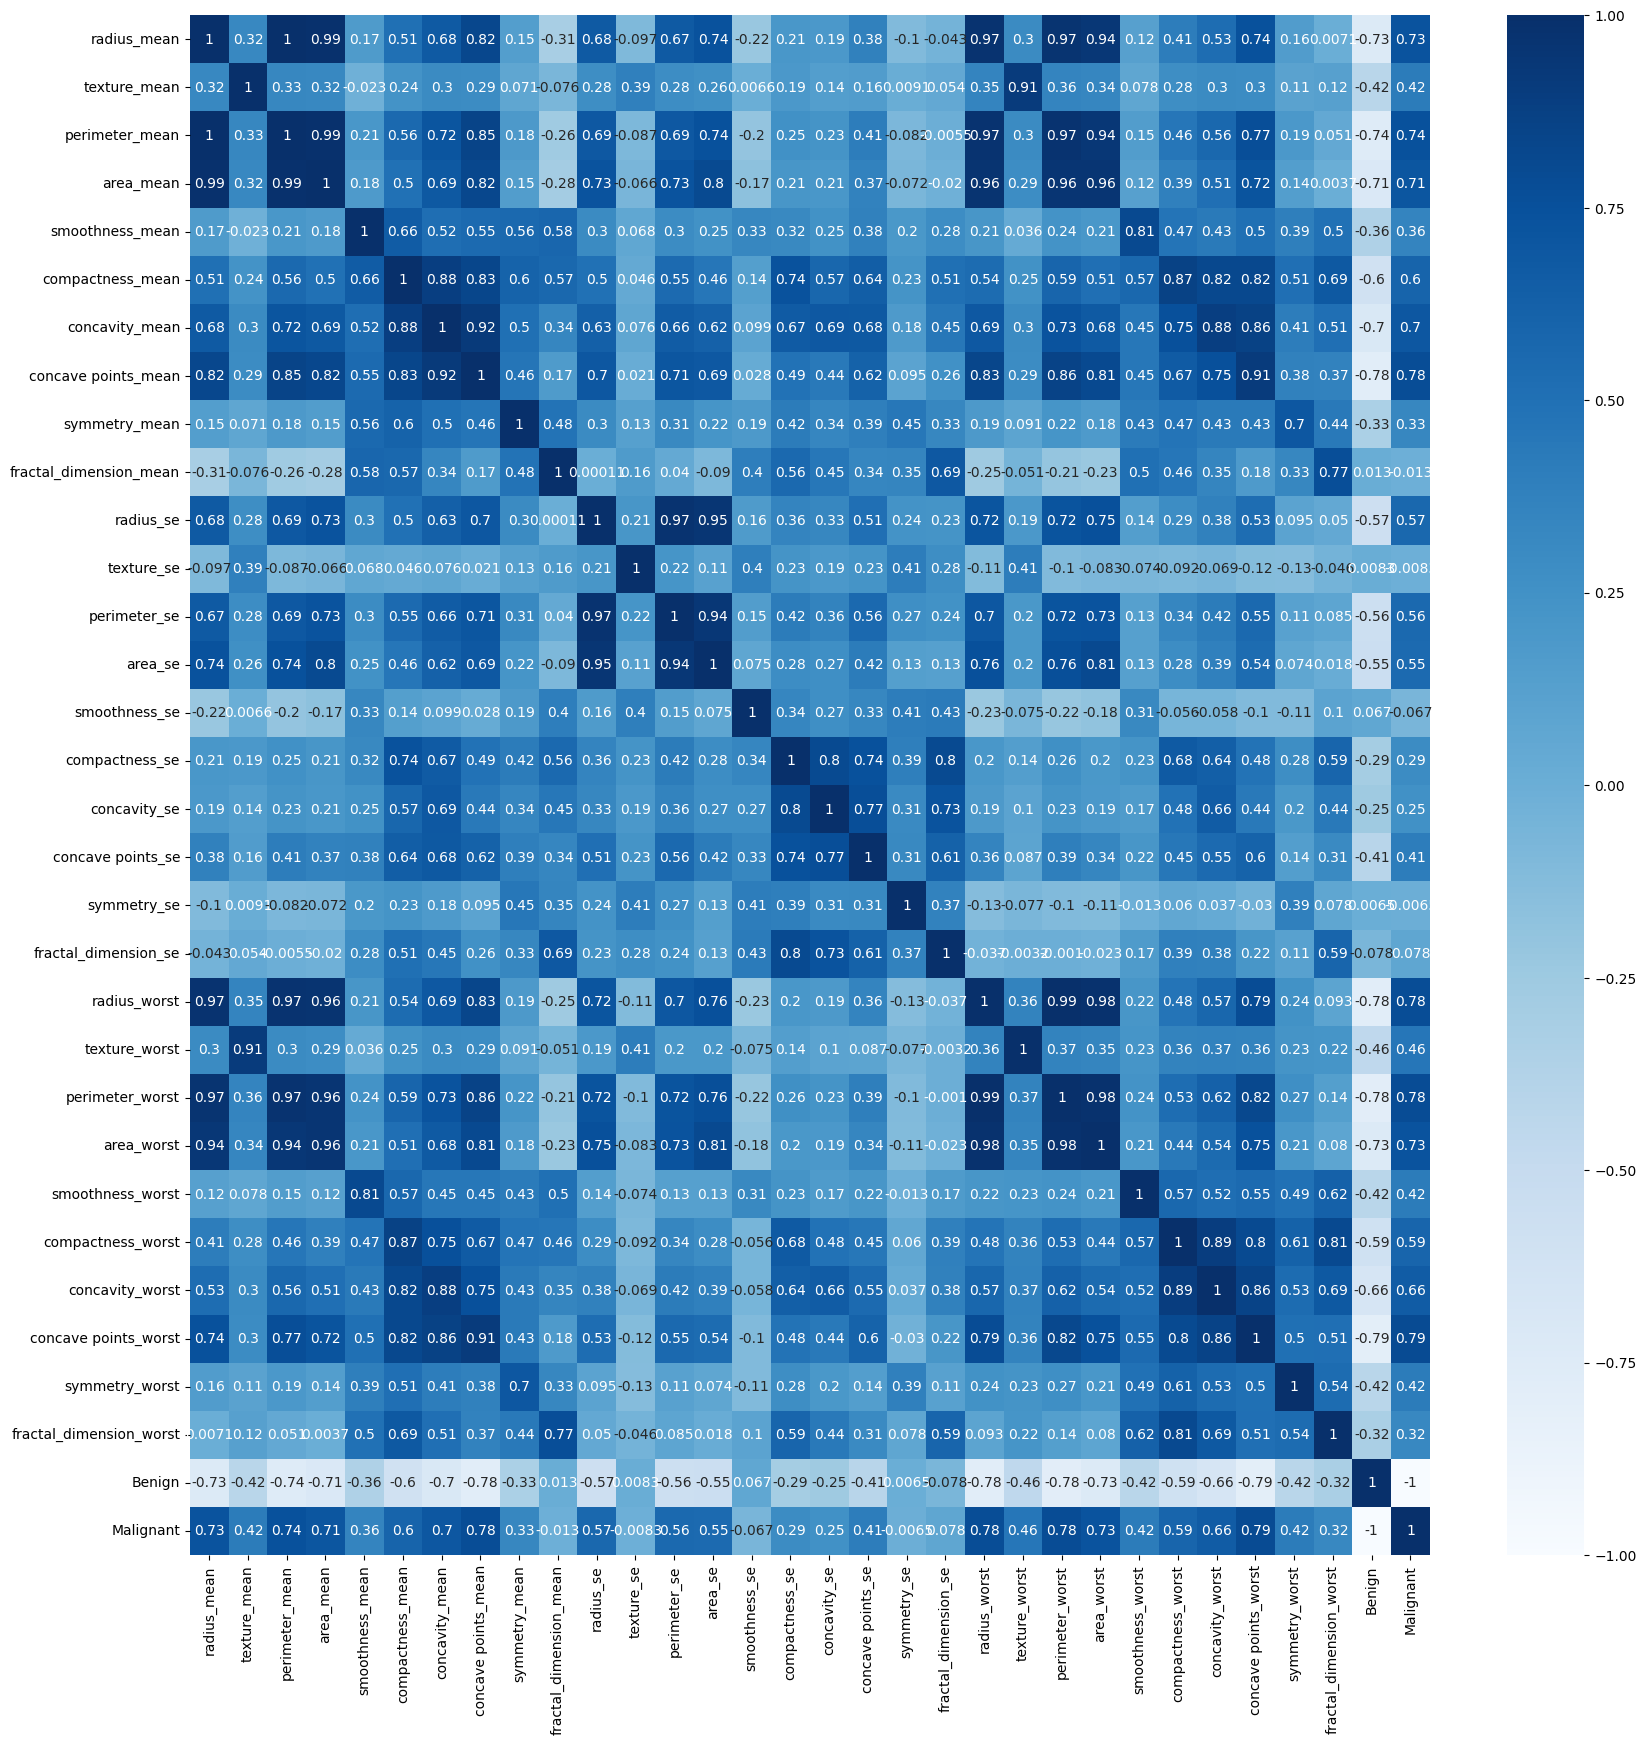

In [86]:
# cross examine with co
plt.figure(figsize=(20,20))
sns.heatmap(cc.corr(),cbar=True,annot=True,cmap='Blues')
plt.show()

From the above heat map, we can see that benign and malignant are negatively linearly associarted with each other, so, we will only list features for benign. 


From the covariance matrix and correlation heat map, We can see that there aren't any features that are remotely definitive for being benign, but there are a lot of features that strongly associate with being malignant.

We can also use heat map to filter out highly correlated variables so that we can reduce the dimension.

In [87]:
cc.corr().loc["Benign"].sort_values()

Malignant                 -1.000000
concave points_worst      -0.793566
perimeter_worst           -0.782914
concave points_mean       -0.776614
radius_worst              -0.776454
perimeter_mean            -0.742636
area_worst                -0.733825
radius_mean               -0.730029
area_mean                 -0.708984
concavity_mean            -0.696360
concavity_worst           -0.659610
compactness_mean          -0.596534
compactness_worst         -0.590998
radius_se                 -0.567134
perimeter_se              -0.556141
area_se                   -0.548236
texture_worst             -0.456903
smoothness_worst          -0.421465
symmetry_worst            -0.416294
texture_mean              -0.415185
concave points_se         -0.408042
smoothness_mean           -0.358560
symmetry_mean             -0.330499
fractal_dimension_worst   -0.323872
compactness_se            -0.292999
concavity_se              -0.253730
fractal_dimension_se      -0.077972
symmetry_se                0

We need to explore the data more to get an idea of the certain features that determines whether a tumor is benign or malignant. This part examines different features of tumors that were identified as benign. First we divide all the tumors that were benign and malignant into their own datasets.

In [88]:
b_group = cc.loc[cc['Benign'] == 1]
m_group = cc.loc[cc['Malignant'] == 1]

In [89]:
b_group.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Benign,Malignant
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,...,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.0,357.0
mean,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,...,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442,1.0,0.0
std,1.780512,3.995125,11.807438,134.287118,0.013446,0.033750,0.043442,0.015909,0.024807,0.006747,...,13.527091,163.601424,0.020013,0.092180,0.140368,0.035797,0.041745,0.013804,0.0,0.0
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.051850,...,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156600,0.055210,1.0,0.0
25%,11.080000,15.150000,70.870000,378.200000,0.083060,0.055620,0.020310,0.015020,0.158000,0.058530,...,78.270000,447.100000,0.110400,0.112000,0.077080,0.051040,0.240600,0.070090,1.0,0.0
50%,12.200000,17.390000,78.180000,458.400000,0.090760,0.075290,0.037090,0.023440,0.171400,0.061540,...,86.920000,547.400000,0.125400,0.169800,0.141200,0.074310,0.268700,0.077120,1.0,0.0
75%,13.370000,19.760000,86.100000,551.100000,0.100700,0.097550,0.059990,0.032510,0.189000,0.065760,...,96.590000,670.000000,0.137600,0.230200,0.221600,0.097490,0.298300,0.085410,1.0,0.0
max,17.850000,33.810000,114.600000,992.100000,0.163400,0.223900,0.410800,0.085340,0.274300,0.095750,...,127.100000,1210.000000,0.200600,0.584900,1.252000,0.175000,0.422800,0.148600,1.0,0.0


In [90]:
m_group.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Benign,Malignant
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.0,212.0
mean,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,...,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530,0.0,1.0
std,3.203971,3.779470,21.854653,367.937978,0.012608,0.053987,0.075019,0.034374,0.027638,0.007573,...,29.457055,597.967743,0.021870,0.170372,0.181507,0.046308,0.074685,0.021553,0.0,0.0
min,10.950000,10.380000,71.900000,361.600000,0.073710,0.046050,0.023980,0.020310,0.130800,0.049960,...,85.100000,508.100000,0.088220,0.051310,0.023980,0.028990,0.156500,0.055040,0.0,1.0
25%,15.075000,19.327500,98.745000,705.300000,0.094010,0.109600,0.109525,0.064620,0.174050,0.056598,...,119.325000,970.300000,0.130475,0.244475,0.326425,0.152750,0.276500,0.076302,0.0,1.0
50%,17.325000,21.460000,114.200000,932.000000,0.102200,0.132350,0.151350,0.086280,0.189900,0.061575,...,138.000000,1303.000000,0.143450,0.356350,0.404900,0.182000,0.310300,0.087600,0.0,1.0
75%,19.590000,23.765000,129.925000,1203.750000,0.110925,0.172400,0.203050,0.103175,0.209850,0.067075,...,159.800000,1712.750000,0.155975,0.447850,0.556175,0.210675,0.359225,0.102625,0.0,1.0
max,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,0.304000,0.097440,...,251.200000,4254.000000,0.222600,1.058000,1.170000,0.291000,0.663800,0.207500,0.0,1.0


Benign tumors cells are known to be smooth compared to malignant tumors cells, we can examine features in relation to the smoothness of the cells.

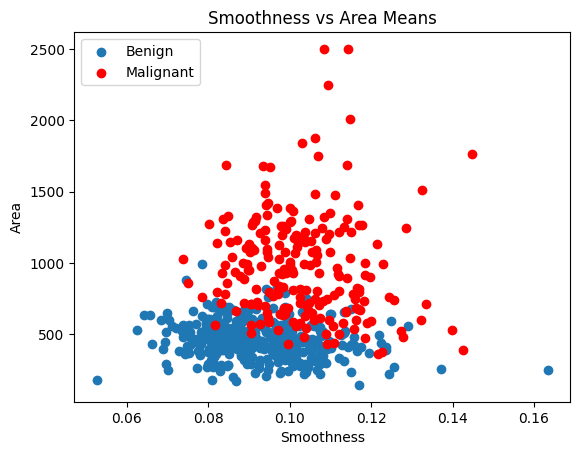

In [91]:
Plots = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['area_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['area_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Area Means')
plt.xlabel('Smoothness')
plt.ylabel('Area')
plt.legend(loc="upper left")
plt.show()


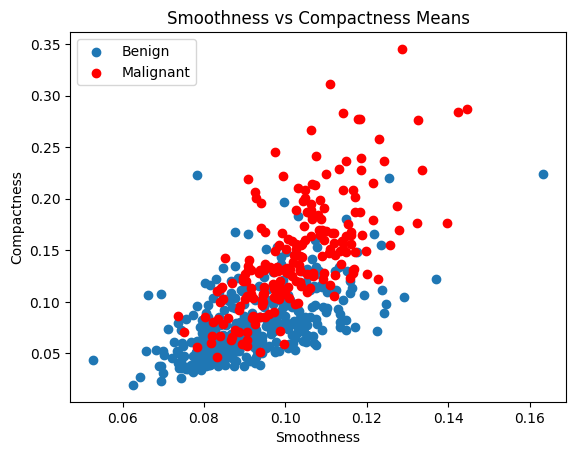

In [92]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['compactness_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['compactness_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Compactness Means')
plt.xlabel('Smoothness')
plt.ylabel('Compactness')
plt.legend(loc="upper left")
plt.show()

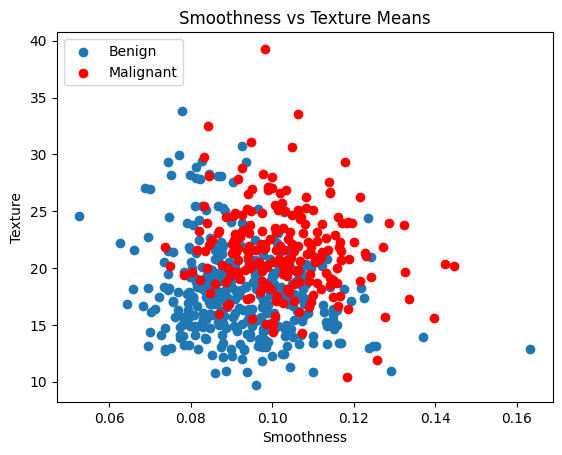

In [93]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['texture_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['texture_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Texture Means')
plt.xlabel('Smoothness')
plt.ylabel('Texture')
plt.legend(loc="upper left")
plt.show()

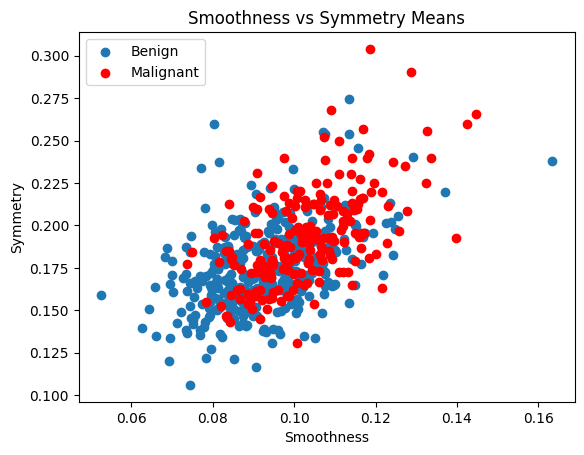

In [94]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['symmetry_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['symmetry_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Symmetry Means')
plt.xlabel('Smoothness')
plt.ylabel('Symmetry')
plt.legend(loc="upper left")
plt.show()

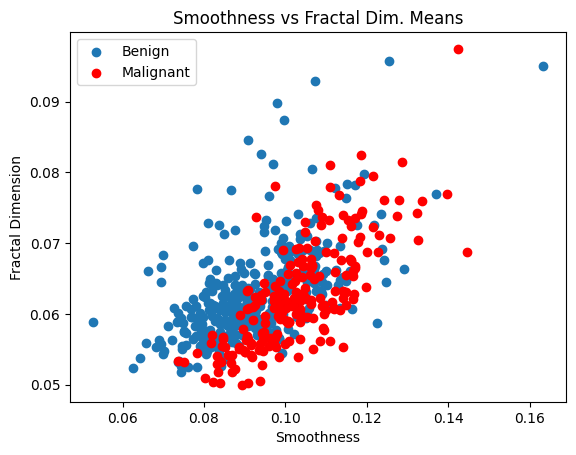

In [95]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['fractal_dimension_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['fractal_dimension_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Fractal Dim. Means')
plt.xlabel('Smoothness')
plt.ylabel('Fractal Dimension')
plt.legend(loc="upper left")
plt.show()

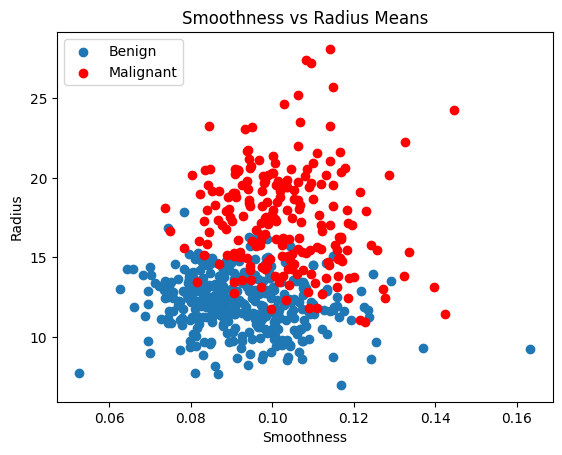

In [96]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['radius_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['radius_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Radius Means')
plt.xlabel('Smoothness')
plt.ylabel('Radius')
plt.legend(loc="upper left")
plt.show()

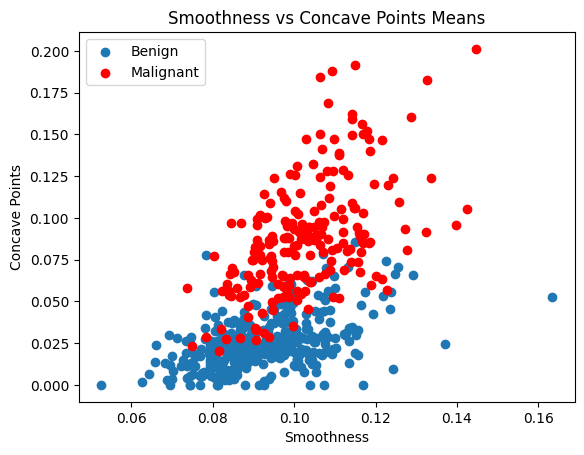

In [97]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['concave points_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['concave points_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Concave Points Means')
plt.xlabel('Smoothness')
plt.ylabel('Concave Points')
plt.legend(loc="upper left")
plt.show()

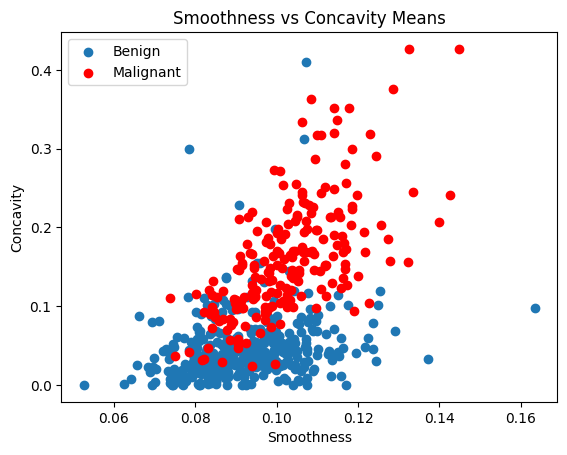

In [98]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['concavity_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['concavity_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Concavity Means')
plt.xlabel('Smoothness')
plt.ylabel('Concavity')
plt.legend(loc="upper left")
plt.show()

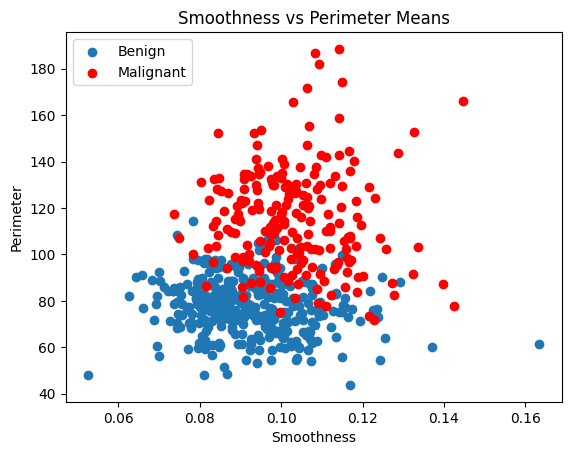

In [99]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['perimeter_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['perimeter_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Perimeter Means')
plt.xlabel('Smoothness')
plt.ylabel('Perimeter')
plt.legend(loc="upper left")
plt.show()

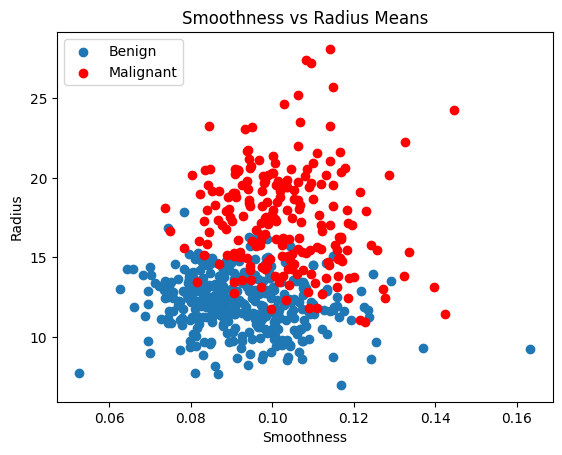

In [100]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(b_group['smoothness_mean'], b_group['radius_mean'], label="Benign")
ax.scatter(m_group['smoothness_mean'], m_group['radius_mean'], color = 'r', label="Malignant")

plt.title('Smoothness vs Radius Means')
plt.xlabel('Smoothness')
plt.ylabel('Radius')
plt.legend(loc="upper left")
plt.show()

In [158]:
from sklearn.feature_selection import mutual_info_classif


X = cc.drop(['Malignant', 'Benign'], axis=1).values
y = cc['Malignant'].values

# Calculate the information gain for each feature
mi_scores = mutual_info_classif(X, y)

# Get the indices of the top 5 scores
top_5 = np.argsort(mi_scores)[::-1][:10]

print("Top 10 malignant features in terms of information gain:")
for i, feature_idx in enumerate(top_5):
    print(f"{i}. {cc.columns[feature_idx]}: {mi_scores[feature_idx]}")



Top 10 malignant features in terms of information gain:
0. perimeter_worst: 0.4719415410649628
1. area_worst: 0.4630928208739771
2. radius_worst: 0.4547573730306669
3. concave points_mean: 0.43974376341767396
4. concave points_worst: 0.4384860048834136
5. perimeter_mean: 0.4034259348225617
6. concavity_mean: 0.37274580533627555
7. radius_mean: 0.3681761297316961
8. area_mean: 0.36331828199966676
9. area_se: 0.33966791698312604


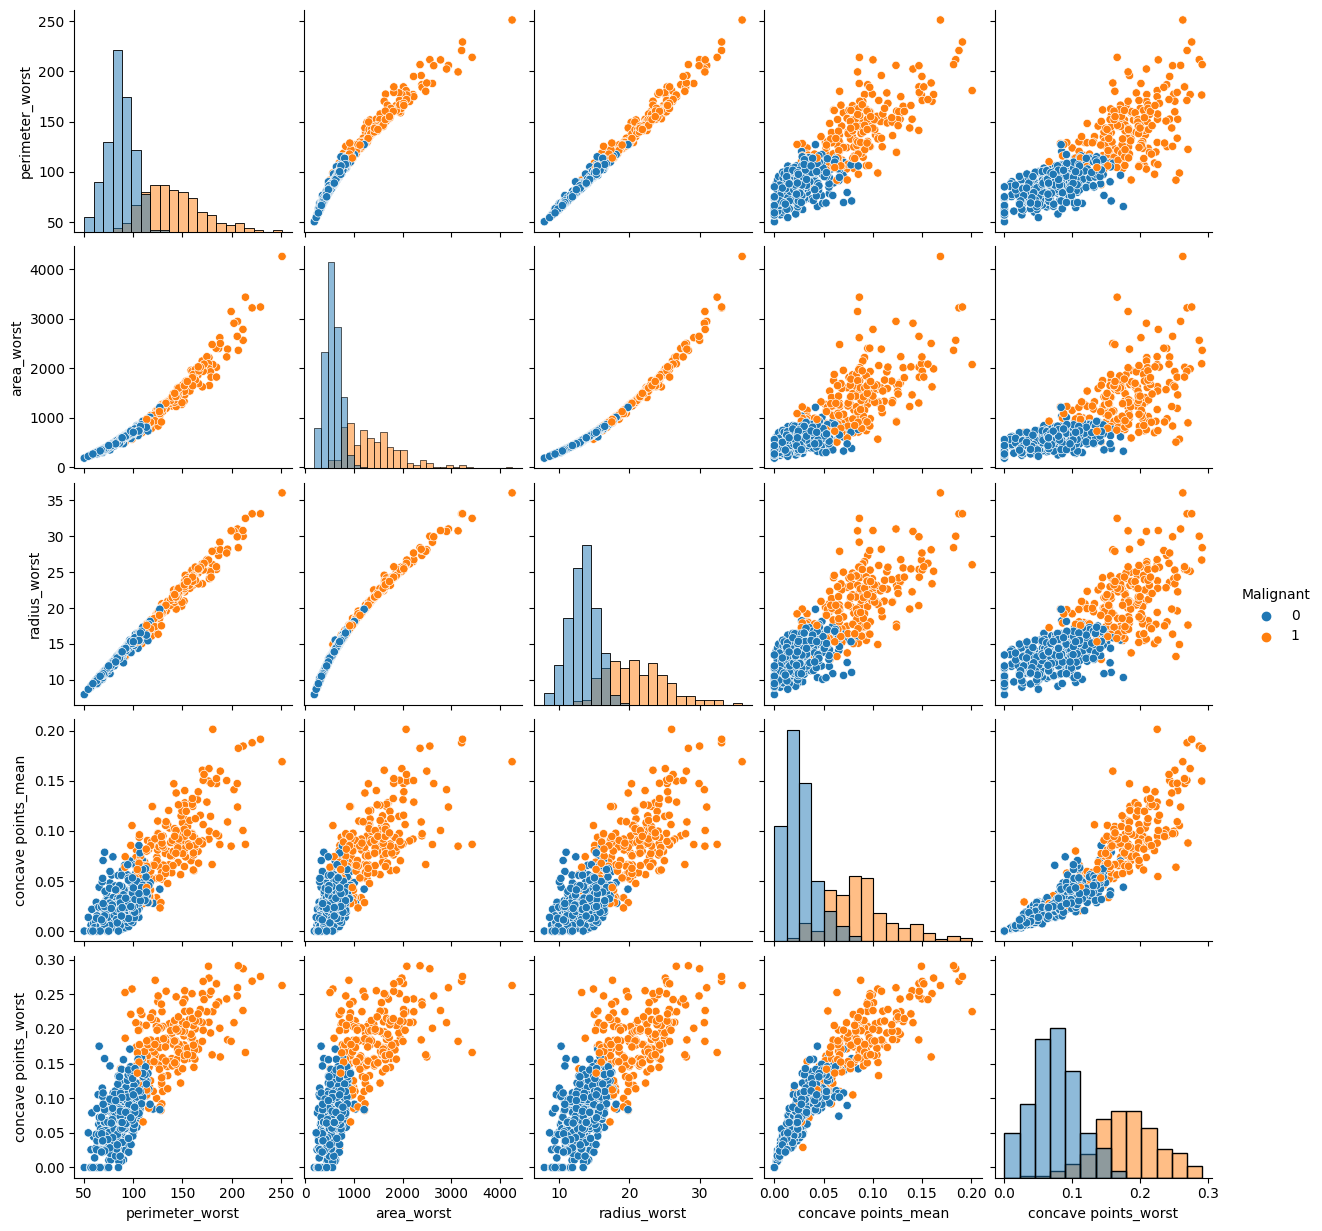

In [102]:
# assuming X contains the features and y contains the target variable
# feat_importance contains the names of the features with highest information gain

# create a new dataframe with only the selected features and target variable
df = cc[cc.columns[top_5]].copy()
df['Malignant'] = cc['Malignant'].copy()
# create a pairplot with scatter plots for each feature
sns.pairplot(df, hue='Malignant', diag_kind='hist')
plt.show()


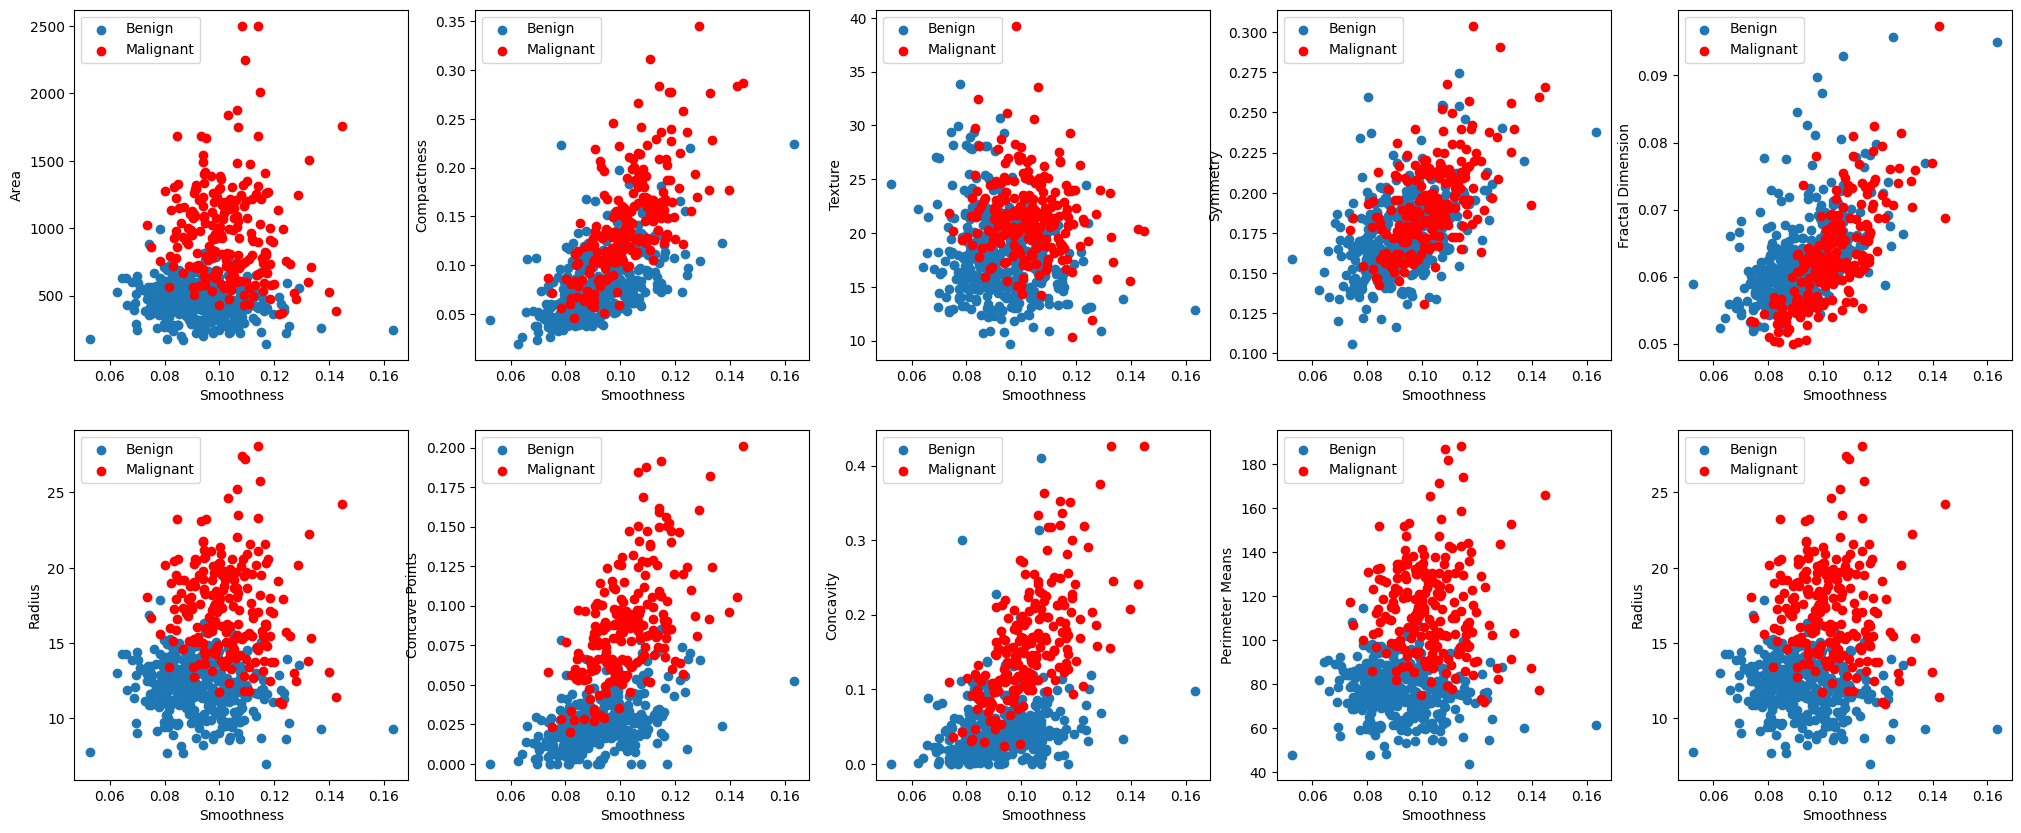

In [103]:
# create a figure with a 2x5 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))


# flatten the axs array so we can access each subplot by index
axs = axs.flatten()


# iterate over each subplot and plot the corresponding data
for i in range(len(axs)):
    ax = axs[i]
    if i == 0:
        ax.scatter(b_group['smoothness_mean'], b_group['area_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['area_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Area')
        ax.legend(loc="upper left")
    elif i == 1:
        ax.scatter(b_group['smoothness_mean'], b_group['compactness_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['compactness_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Compactness')
        ax.legend(loc="upper left")
    elif i == 2:
        ax.scatter(b_group['smoothness_mean'], b_group['texture_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['texture_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Texture')
        ax.legend(loc="upper left")
    elif i == 3:
        ax.scatter(b_group['smoothness_mean'], b_group['symmetry_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['symmetry_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Symmetry')
        ax.legend(loc="upper left")
    elif i == 4:
        ax.scatter(b_group['smoothness_mean'], b_group['fractal_dimension_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['fractal_dimension_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Fractal Dimension')
        ax.legend(loc="upper left")
    elif i == 5:
        ax.scatter(b_group['smoothness_mean'], b_group['radius_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['radius_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Radius')
        ax.legend(loc="upper left")
    elif i == 6:
        ax.scatter(b_group['smoothness_mean'], b_group['concave points_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['concave points_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Concave Points')
        ax.legend(loc="upper left")
    elif i == 7:
        ax.scatter(b_group['smoothness_mean'], b_group['concavity_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['concavity_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Concavity')
        ax.legend(loc="upper left")
    elif i == 8:
        ax.scatter(b_group['smoothness_mean'], b_group['perimeter_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['perimeter_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Perimeter Means')
        ax.legend(loc="upper left")
    elif i == 9:
        ax.scatter(b_group['smoothness_mean'], b_group['radius_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['radius_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Radius')
        ax.legend(loc="upper left")

# Observations

Based on the scatter plots, malignant and benign cells labels are correlated to cell size. Features such as concavity, area, radius, concave points, perimeter with cell smoothness taken into account influences the classification of a tumor cell. 


Before we start, remind yourself that in covariance matrix,
*   area_worst
*   area_mean
*   perimeter_worst
*   area_se
*   perimeter_mean
*   radius_worst
*   texture_worst
*   radius_mean

are negatively associated with benign;

in correlation matrix,
*   concave points_worst
*   concave points_mean 
*   concavity_mean
*   concavity_worst
*   compactness_mean
*   compactness_worst
*   radius_se
*   perimeter_se 

are the other features that are negatively correlated with being benign.



<h2>Decision Tree</h2>

In [104]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

X = cc.drop(['Malignant', 'Benign'], axis=1) # The data used for training

cols_intersted = ["area_worst","area_mean","perimeter_worst","area_se","perimeter_mean","radius_worst","texture_worst","radius_mean","concave points_worst",
                  "concave points_mean","concavity_mean","concavity_worst","compactness_mean","compactness_worst","radius_se","perimeter_se"]
X_comp = cc[cols_intersted] # used to compare the accuracy with using full dataset to find effectiveness of covariance and correlations

y = cc['Malignant'] # The actual labels

In [105]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=7).fit(X, y)

We can visualize the decision tree.

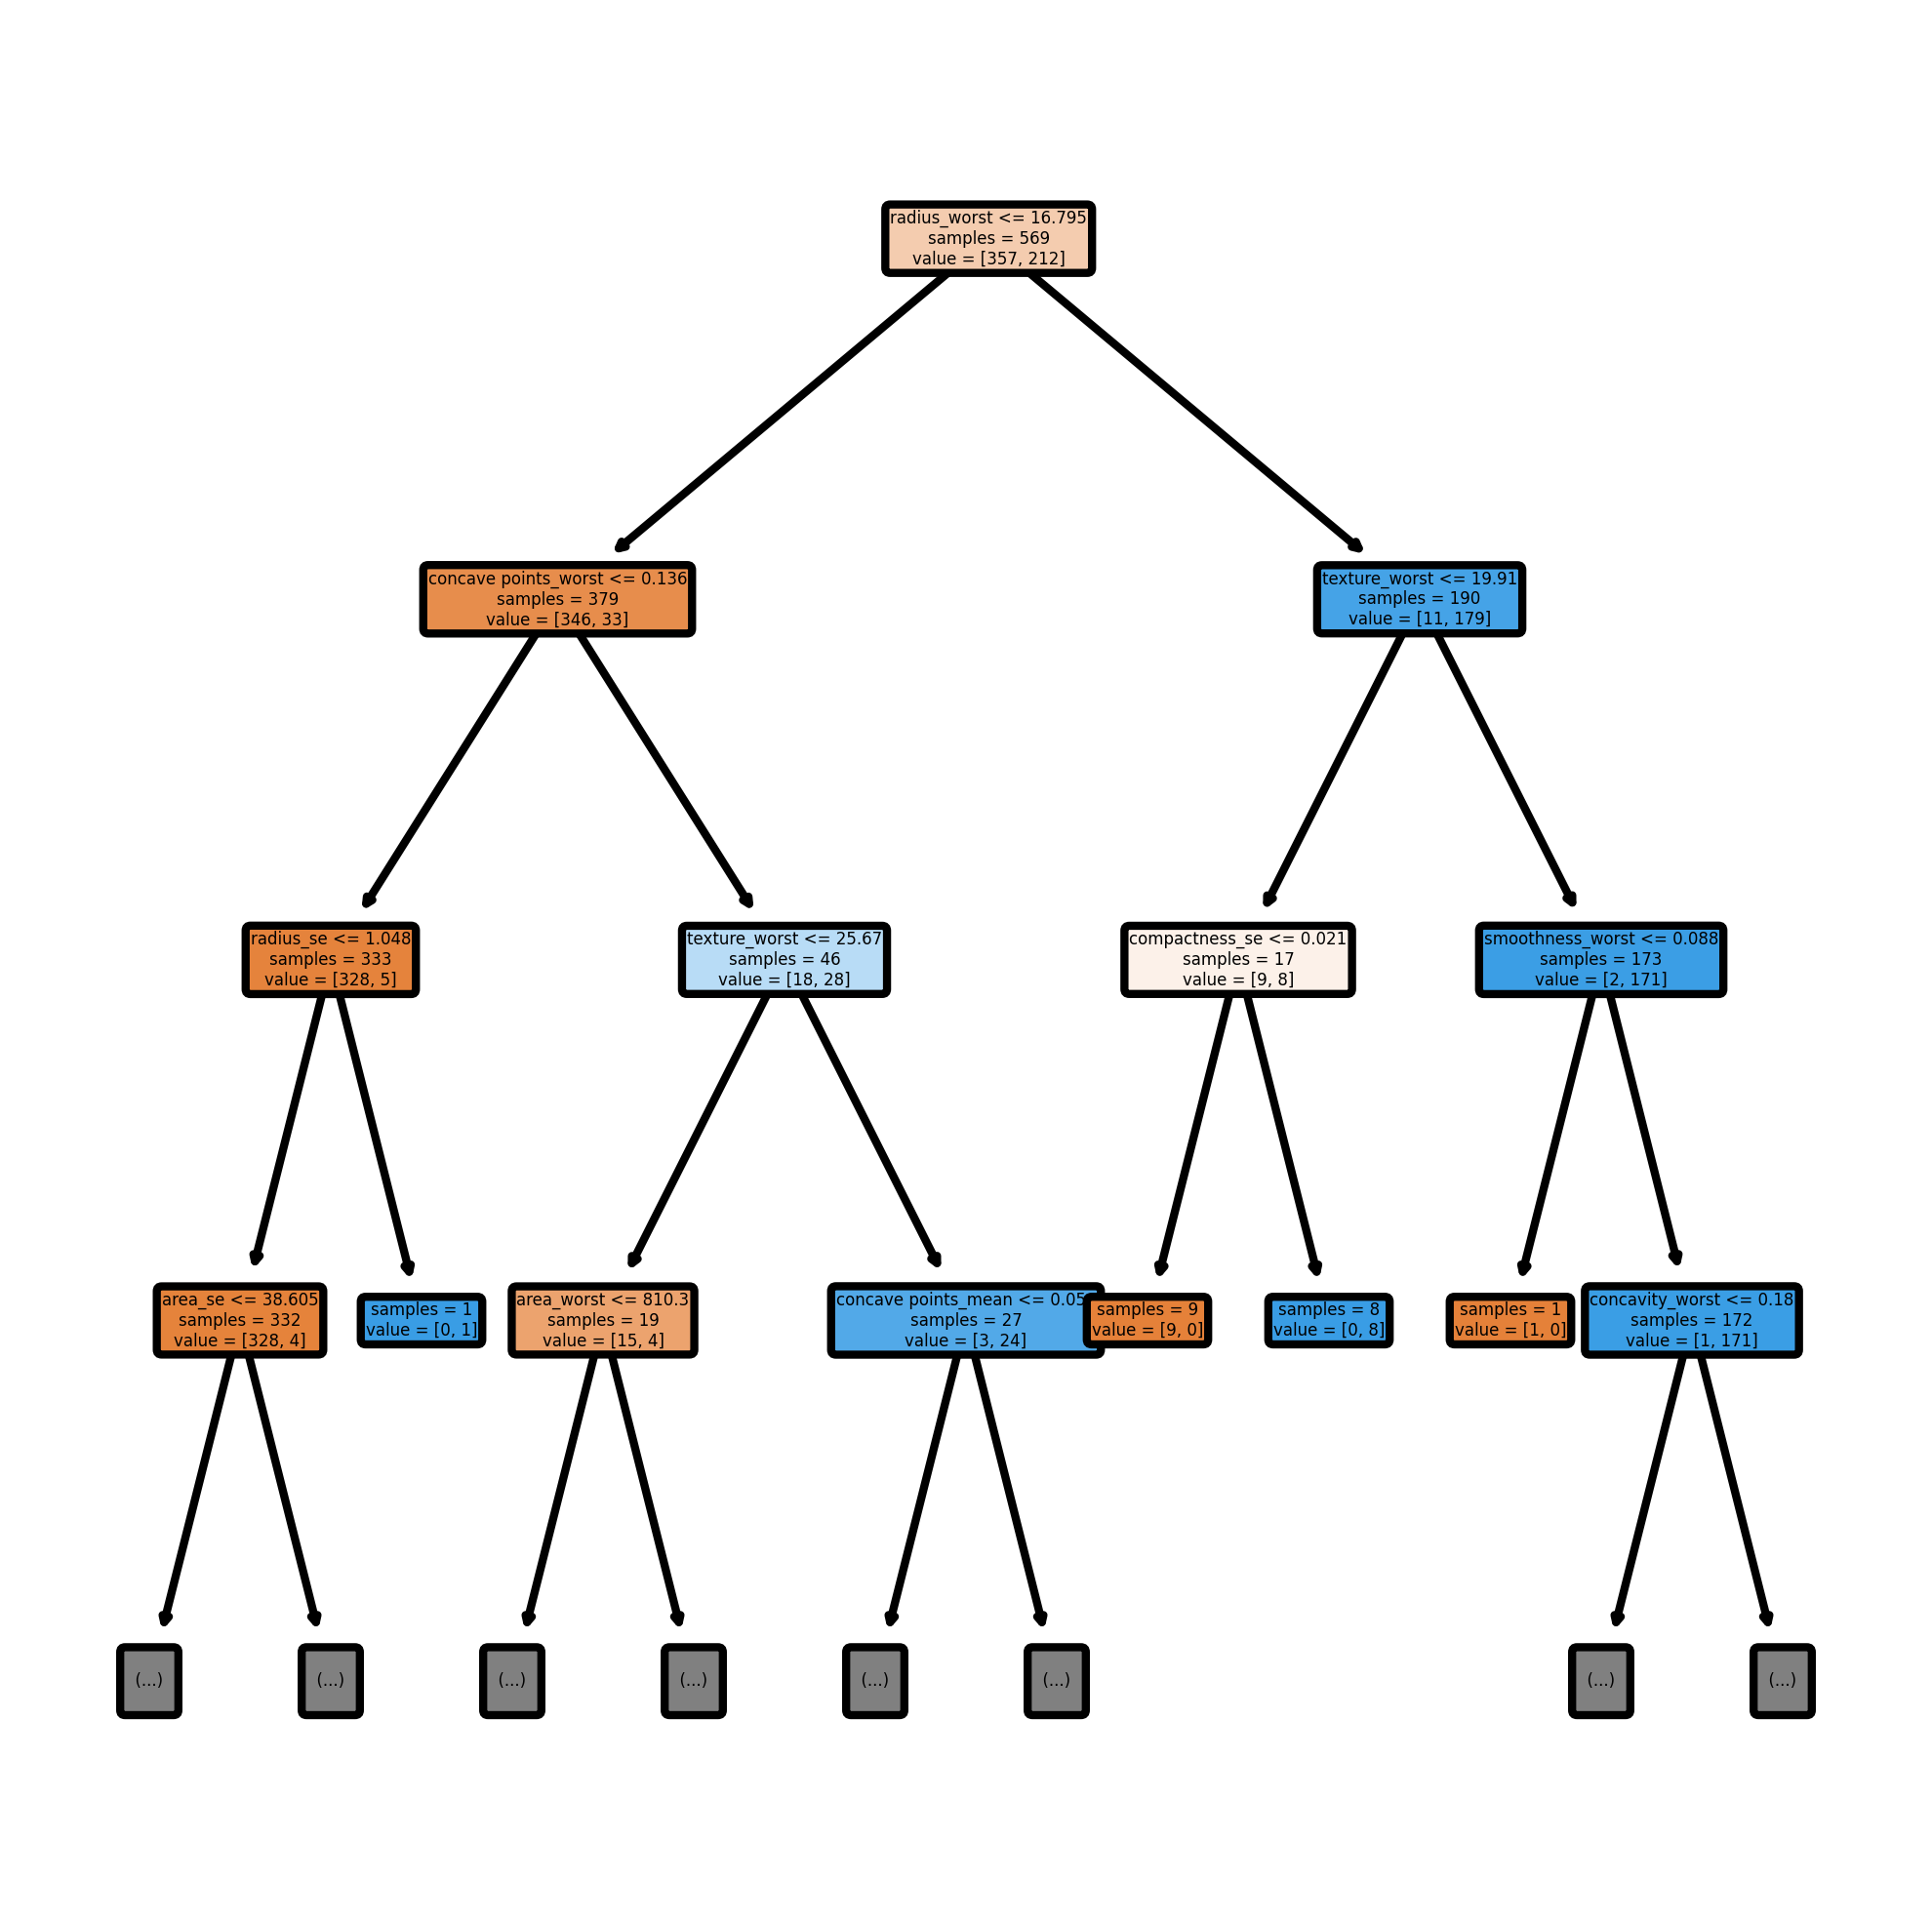

In [106]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
tree.plot_tree(decision_tree,
           feature_names = list(X.columns),
           filled = True,
           max_depth=3,
           fontsize=2,
           rounded=True,
           impurity=False);

In [107]:

scores = cross_val_score(decision_tree, X, y, cv=10)
print(scores)
print("Decision Tree has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.94736842 0.84210526 0.9122807  0.89473684 0.92982456 0.89473684
 0.9122807  0.94736842 0.9122807  1.        ]
Decision Tree has 0.92 accuracy with a standard deviation of 0.04


In [108]:
scores = cross_val_score(decision_tree, X_comp, y, cv=10)
print(scores)
print("Decision Tree using dataset with high correlations or covariance has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.9122807  0.85964912 0.9122807  0.92982456 0.92982456 0.92982456
 0.94736842 0.94736842 0.96491228 1.        ]
Decision Tree using dataset with high correlations or covariance has 0.93 accuracy with a standard deviation of 0.03


<h2> Random Forest </h2>

Some hyperparameter finding algorithm I wrote in 320 lol

In [109]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

def fit_score_model(name, model, params, X_in, y_in):
    scoring = ['f1_macro', 'accuracy']
    # Find the best model in terms of accuracy
    clf = GridSearchCV(model, params, scoring=scoring, cv=10, refit='accuracy').fit(X_in, y_in)
    best_model = clf.best_estimator_
    best_params = clf.best_params_
    # Score the model with 10-fold cross validation
    scores = cross_validate(model, X_in, y_in, cv=10, scoring=scoring)
    # Calculate CV standard error estimates
    acc_mean = sum(scores['test_accuracy'])/10
    f1_mean = sum(scores['test_f1_macro'])/10
    
    # Print the results
    print(name)
    print('----------')
    print('Parameters')
    print(best_params)
    print(f'Accuracy (Average: {acc_mean})')
    print(scores['test_accuracy'])
    print(f'F1 Score (Average: {f1_mean})')
    print(scores['test_f1_macro'])
    print()
    
    return scores

In [110]:
knn_scores_full = fit_score_model('K Nearest Neighbors', KNeighborsClassifier(), {'n_neighbors': range(1, 20)}, X, y)
rf_scores_full = fit_score_model('Random Forest', RandomForestClassifier(), {'n_estimators': range(1, 10), 'max_depth': range(1, 4)}, X, y)

K Nearest Neighbors
----------
Parameters
{'n_neighbors': 14}
Accuracy (Average: 0.9297619047619046)
[0.9122807  0.87719298 0.89473684 0.96491228 0.94736842 0.92982456
 0.96491228 0.92982456 0.9122807  0.96428571]
F1 Score (Average: 0.924149193560147)
[0.9066492  0.86358974 0.88690476 0.96148649 0.94286669 0.92460317
 0.96230159 0.92297297 0.90821256 0.96190476]

Random Forest
----------
Parameters
{'max_depth': 3, 'n_estimators': 9}
Accuracy (Average: 0.9648496240601503)
[0.98245614 0.92982456 0.94736842 0.94736842 1.         0.98245614
 0.96491228 0.98245614 0.94736842 0.96428571]
F1 Score (Average: 0.9620317006539845)
[0.98164251 0.92460317 0.94286669 0.94153846 1.         0.98132984
 0.96148649 0.98095556 0.94398952 0.96190476]



In [111]:
knn_scores_high = fit_score_model('K Nearest Neighbors using dataset with high correlations or covariance', KNeighborsClassifier(), {'n_neighbors': range(1, 20)}, X_comp, y)
rf_scores_high = fit_score_model('Random Forest using dataset with high correlations or covariance', RandomForestClassifier(), {'n_estimators': range(1, 10), 'max_depth': range(1, 4)}, X_comp, y)

K Nearest Neighbors using dataset with high correlations or covariance
----------
Parameters
{'n_neighbors': 14}
Accuracy (Average: 0.9297619047619046)
[0.9122807  0.87719298 0.89473684 0.96491228 0.94736842 0.92982456
 0.96491228 0.92982456 0.9122807  0.96428571]
F1 Score (Average: 0.9240698284807818)
[0.9066492  0.86358974 0.88690476 0.96148649 0.94286669 0.92460317
 0.96230159 0.92297297 0.90821256 0.96111111]

Random Forest using dataset with high correlations or covariance
----------
Parameters
{'max_depth': 3, 'n_estimators': 6}
Accuracy (Average: 0.9613721804511277)
[0.98245614 0.89473684 0.9122807  0.96491228 0.98245614 0.98245614
 0.98245614 0.98245614 0.94736842 0.98214286]
F1 Score (Average: 0.9581546534509675)
[0.98164251 0.88690476 0.9025641  0.96148649 0.98095556 0.98132984
 0.98095556 0.98095556 0.94398952 0.98076262]



T-Test

In [112]:
from scipy import stats

_, p1 = stats.ttest_ind(knn_scores_full['test_accuracy'], rf_scores_full['test_accuracy'])
_, p2 = stats.ttest_ind(knn_scores_full['test_f1_macro'], rf_scores_full['test_f1_macro'])
print(f'Accuracy P-value: {p1}')
print(f'F1-score P-value: {p2}')

Accuracy P-value: 0.008895471085277655
F1-score P-value: 0.009458001953904727


In [113]:
from scipy import stats

_, p1 = stats.ttest_ind(knn_scores_high['test_accuracy'], rf_scores_high['test_accuracy'])
_, p2 = stats.ttest_ind(knn_scores_high['test_f1_macro'], rf_scores_high['test_f1_macro'])
print(f'Accuracy P-value: {p1}')
print(f'F1-score P-value: {p2}')

Accuracy P-value: 0.039693661293904184
F1-score P-value: 0.04159911672604264


The distributions are very different (obviously)

<h2> All the Naive Bayes Classifier </h2>

In [114]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

In [115]:
# naive bayes
gnb = GaussianNB()
scores = cross_validate(gnb, X, y, cv=10)["test_score"]
print(scores)
print("Naive bayes has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.94736842 0.87719298 0.89473684 0.92982456 0.94736842 0.96491228
 0.92982456 0.96491228 0.94736842 0.96428571]
Naive bayes has 0.94 accuracy with a standard deviation of 0.03


In [116]:
gnb = GaussianNB()
scores = cross_validate(gnb, X_comp, y, cv=10)["test_score"]
print(scores)
print("Naive bayes using dataset with high correlations or covariance has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.94736842 0.84210526 0.89473684 0.9122807  0.92982456 0.94736842
 0.92982456 0.96491228 0.94736842 0.96428571]
Naive bayes using dataset with high correlations or covariance has 0.93 accuracy with a standard deviation of 0.04


In [117]:
# naive bayes for multimonially distributed data
mnb = MultinomialNB(force_alpha=True)
scores = cross_validate(mnb, X, y, cv=10)["test_score"]
print(scores)
print("Multinominal naive bayes has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.85964912 0.87719298 0.87719298 0.92982456 0.87719298 0.87719298
 0.9122807  0.92982456 0.89473684 0.89285714]
Multinominal naive bayes has 0.89 accuracy with a standard deviation of 0.02


In [118]:
mnb = MultinomialNB(force_alpha=True)
scores = cross_validate(mnb, X_comp, y, cv=10)["test_score"]
print(scores)
print("Multinominal naive bayes using dataset with high correlations or covariance has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.85964912 0.87719298 0.89473684 0.92982456 0.87719298 0.92982456
 0.9122807  0.94736842 0.89473684 0.89285714]
Multinominal naive bayes using dataset with high correlations or covariance has 0.90 accuracy with a standard deviation of 0.03


In [119]:
# naive bayes for multinominally distributed imbalanced data
cnb = ComplementNB(force_alpha=True)
scores = cross_validate(cnb, X, y, cv=10)["test_score"]
print(scores)
print("Complement naive bayes has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.85964912 0.87719298 0.87719298 0.92982456 0.87719298 0.87719298
 0.9122807  0.92982456 0.89473684 0.89285714]
Complement naive bayes has 0.89 accuracy with a standard deviation of 0.02


In [120]:
cnb = ComplementNB(force_alpha=True)
scores = cross_validate(cnb, X_comp, y, cv=10)["test_score"]
print(scores)
print("Complement naive bayes using dataset with high correlations or covariance has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.85964912 0.87719298 0.89473684 0.92982456 0.87719298 0.92982456
 0.9122807  0.94736842 0.89473684 0.89285714]
Complement naive bayes using dataset with high correlations or covariance has 0.90 accuracy with a standard deviation of 0.03


<h2> Logistic Regression </h2>

In [121]:
from sklearn.linear_model import LogisticRegression

In [122]:
# logistic regression with no regularizer
lrg_np_100 = LogisticRegression(random_state=10, solver="saga") 
lrg_np_500 = LogisticRegression(random_state=10, solver="saga", max_iter=500) # max iter is set because of the convergence warning
scores_100 = cross_validate(lrg_np_100, X, y, cv=10)["test_score"]
scores_500 = cross_validate(lrg_np_500, X, y, cv=10)["test_score"]
print("Logistic regression with no penalty and 100 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_100.mean(), scores_100.std()))
print("Logistic regression with no penalty and 500 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_500.mean(), scores_500.std()))

Logistic regression with no penalty and 100 max iteration has 0.91 accuracy with a standard deviation of 0.02
Logistic regression with no penalty and 500 max iteration has 0.92 accuracy with a standard deviation of 0.03


In [123]:
scores_100 = cross_validate(lrg_np_100, X_comp, y, cv=10)["test_score"]
scores_500 = cross_validate(lrg_np_500, X_comp, y, cv=10)["test_score"]
print("Logistic regression with no penalty and 100 max iteration using dataset with high correlations or covariance has %0.2f accuracy with a standard deviation of %0.2f" % (scores_100.mean(), scores_100.std()))
print("Logistic regression with no penalty and 500 max iteration using dataset with high correlations or covariance has %0.2f accuracy with a standard deviation of %0.2f" % (scores_500.mean(), scores_500.std()))

Logistic regression with no penalty and 100 max iteration using dataset with high correlations or covariance has 0.91 accuracy with a standard deviation of 0.02
Logistic regression with no penalty and 500 max iteration using dataset with high correlations or covariance has 0.92 accuracy with a standard deviation of 0.03


Seems like adding more iterations does not help with converging, though it increases both the average accuracy and the standard deviation of the accuracy.

In [124]:
# logistic regression with l1 regularizer
lrg_l1_100 = LogisticRegression(penalty = "l1", random_state=10, solver="saga") 
lrg_l1_500 = LogisticRegression(penalty = "l1", random_state=10, solver="saga", max_iter=500) # max iter is set because of the convergence warning
scores_100 = cross_validate(lrg_l1_100, X, y, cv=10)["test_score"]
scores_500 = cross_validate(lrg_l1_500, X, y, cv=10)["test_score"]
print("Logistic regression with l1 regularizer and 100 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_100.mean(), scores_100.std()))
print("Logistic regression with l1 regularizer and 500 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_500.mean(), scores_500.std()))

Logistic regression with l1 regularizer and 100 max iteration has 0.91 accuracy with a standard deviation of 0.02
Logistic regression with l1 regularizer and 500 max iteration has 0.92 accuracy with a standard deviation of 0.03


In [125]:
scores_100 = cross_validate(lrg_l1_100, X_comp, y, cv=10)["test_score"]
scores_500 = cross_validate(lrg_l1_500, X_comp, y, cv=10)["test_score"]
print("Logistic regression with l1 regularizer and 100 max iteration using dataset with high correlations or covariance has %0.2f accuracy with a standard deviation of %0.2f" % (scores_100.mean(), scores_100.std()))
print("Logistic regression with l1 regularizer and 500 max iteration using dataset with high correlations or covariance has %0.2f accuracy with a standard deviation of %0.2f" % (scores_500.mean(), scores_500.std()))

Logistic regression with l1 regularizer and 100 max iteration using dataset with high correlations or covariance has 0.91 accuracy with a standard deviation of 0.02
Logistic regression with l1 regularizer and 500 max iteration using dataset with high correlations or covariance has 0.92 accuracy with a standard deviation of 0.03


In [126]:
# logistic regression with l2 regularizer
lrg_l2_100 = LogisticRegression(penalty = "l2", random_state=10, solver="saga") 
lrg_l2_500 = LogisticRegression(penalty = "l2", random_state=10, solver="saga", max_iter=500) # max iter is set because of the convergence warning
scores_100 = cross_validate(lrg_l2_100, X, y, cv=10)["test_score"]
scores_500 = cross_validate(lrg_l2_500, X, y, cv=10)["test_score"]
print("Logistic regression with l2 regularizer and 100 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_100.mean(), scores_100.std()))
print("Logistic regression with l2 regularizer and 500 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_500.mean(), scores_500.std()))

Logistic regression with l2 regularizer and 100 max iteration has 0.91 accuracy with a standard deviation of 0.02
Logistic regression with l2 regularizer and 500 max iteration has 0.92 accuracy with a standard deviation of 0.03


In [127]:
scores_100 = cross_validate(lrg_l2_100, X_comp, y, cv=10)["test_score"]
scores_500 = cross_validate(lrg_l2_500, X_comp, y, cv=10)["test_score"]
print("Logistic regression with l2 regularizer and 100 max iteration using dataset with high correlations or covariance has %0.2f accuracy with a standard deviation of %0.2f" % (scores_100.mean(), scores_100.std()))
print("Logistic regression with l2 regularizer and 500 max iteration using dataset with high correlations or covariance has %0.2f accuracy with a standard deviation of %0.2f" % (scores_500.mean(), scores_500.std()))

Logistic regression with l2 regularizer and 100 max iteration using dataset with high correlations or covariance has 0.91 accuracy with a standard deviation of 0.02
Logistic regression with l2 regularizer and 500 max iteration using dataset with high correlations or covariance has 0.92 accuracy with a standard deviation of 0.03


In [128]:
lrg_np_coef = LogisticRegression(random_state=10, solver="saga", max_iter=500).fit(X,y).coef_
lrg_l1_coef = LogisticRegression(penalty = "l1", random_state=10, solver="saga", max_iter=500).fit(X,y).coef_
lrg_l2_coef = LogisticRegression(penalty = "l2", random_state=10, solver="saga", max_iter=500).fit(X,y).coef_
print("Logistic regression with no penalty has weights: ",lrg_np_coef, " which sums to ", np.sum([abs(i) for i in lrg_np_coef]))
print("Logistic regression with l1 regularizer has weights: ",lrg_l1_coef, " which sums to ", np.sum([abs(i) for i in lrg_l1_coef]))
print("Logistic regression with l2 regularizer has weights: ",lrg_l2_coef, " which sums to ", np.sum([abs(i) for i in lrg_l2_coef]))

Logistic regression with no penalty has weights:  [[-7.42562041e-03 -1.10662760e-02 -4.28690479e-02 -1.64458453e-02
  -7.27699137e-05  3.43148394e-05  1.37631104e-04  5.98317517e-05
  -1.39915395e-04 -5.84446154e-05 -7.74655774e-05 -8.70147107e-04
  -7.90819567e-05  1.25838194e-02 -5.36284008e-06  7.86976585e-06
   1.35190107e-05  1.62957689e-06 -1.43648091e-05 -1.27185876e-06
  -7.72417229e-03 -1.34994726e-02 -4.23591768e-02  2.32743619e-02
  -9.12780921e-05  1.69348136e-04  3.18210782e-04  7.89668808e-05
  -1.80422408e-04 -5.10173152e-05]]  which sums to  0.1797106563648362
Logistic regression with l1 regularizer has weights:  [[-7.38949923e-03 -1.10355604e-02 -4.28548517e-02 -1.64335190e-02
  -3.24099280e-05  8.17732098e-06  9.72438246e-05  1.94359390e-05
  -9.95987833e-05 -1.80731780e-05 -3.70815832e-05 -8.30510322e-04
  -3.87504474e-05  1.25537034e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.68790205e-03 -1.34716930e-02

Regularizer does not help with accuracy or keeping the weights small, at least for a small dataset that is. 

<h1> Feedforward Neural Network (FNN) </h1>

In [129]:
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

In [130]:


# Builds the model layer by layer
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Compiles the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [135]:
# K-fold cross validation since we have a small dataset
kf = KFold(n_splits=10, shuffle=True, random_state=4)
X = cc.drop(['Malignant', 'Benign'], axis=1).values # The data used for training
y = cc['Malignant'].values # The actual labels

In [136]:
# Train the model and evaluate it for each fold
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
   

    model.fit(X_train, y_train, epochs=10,batch_size=7, verbose=0)
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    scores.append(accuracy_score(y_test, y_pred))

2/2 [==============================] - 0s 5ms/step


In [137]:
scores

[0.8771929824561403,
 0.8771929824561403,
 0.8771929824561403,
 0.9122807017543859,
 0.9649122807017544,
 0.9473684210526315,
 0.9122807017543859,
 0.9298245614035088,
 0.9649122807017544,
 0.9642857142857143]

We can see that it occasionally dips but the overall accuracy improves over time.

In [138]:
# N-fold cross validation with sklearn
def optim_folds(X,y, min, max, step):
    k = []
    models = []
    # Loop through the number of folds
    while min < max:
        # Builds the model 
        model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


        kf = KFold(n_splits=min, shuffle=True, random_state=4)
        scores = []
        # Train the model and evaluate it for each fold
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]


            model.fit(X_train, y_train, epochs=10,batch_size=7, verbose=0)
            y_pred = model.predict(X_test)
            y_pred = np.round(y_pred)
            scores.append(accuracy_score(y_test, y_pred))
        k.append(scores[-1])
        models.append(model)
        min += step
    # Returns the final accuracy and model for each n-folds
    return k, models

In [139]:
# Run the function
# be careful, this takes a while to run
# ran it for 50 folds and it took 1 hour 
models, scores = optim_folds(X,y, 2, 10, 1)


2/2 [==============================] - 0s 5ms/step


Dont even try lmao to rerun this, un less you want to retrain a model ofer 1200 times 

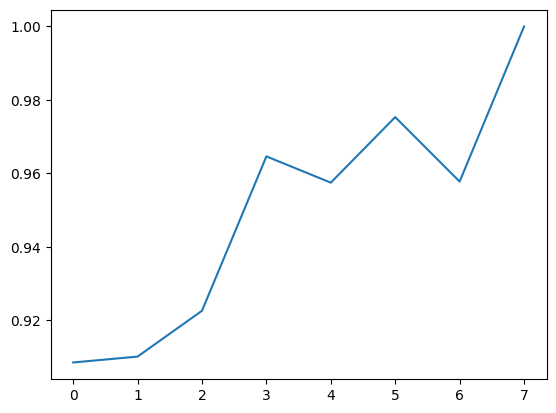

In [140]:
# Plot the accuracy for each n-folds
plt.plot(models)

In [141]:
# Hyperparameter tuning

# Optimizing the number of layers
def optim_layers(X_train,y_train,X_test,y_test, min, max, step):
    layer = [tf.keras.layers.Dense(10, activation='relu')]
    models = []
    losses = []
    while min < max:
        layers = [elem for elem in layer for i in range(min)]
        model = tf.keras.Sequential([layers].append(tf.keras.layers.Dense(1, activation='sigmoid')))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10,batch_size=7, verbose=0)
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f'Num Layers: {min}  \t\t Test Accuracy: {acc} \t Test Loss: {loss}')
        losses.append(loss)
        min += step
    return losses
    
# Optimizing the number of neurons
def optim_neurons(X_train,y_train,X_test,y_test, min, max, step):
    losses = []
    while min < max:
        model = tf.keras.Sequential([
        tf.keras.layers.Dense(min, activation='relu'),
        tf.keras.layers.Dense(min, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10,batch_size=7, verbose=0)
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f'Num Neurons: {min}  \t\t Test Accuracy: {acc} \t Test Loss: {loss}')
        losses.append(loss)
        min += step
    return losses

# Optimizing the batch size
def optim_batch(X_train,y_train,X_test,y_test, min, max, step):
    losses = []
    while min < max:
        model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10,batch_size=min, verbose=0)
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f'Batch Size: {min}  \t\t Test Accuracy: {acc} \t Test Loss: {loss}')
        losses.append(loss)
        min += step
    return losses
    
# Optimizing the number of epochs
def optim_epochs(X_train,y_train,X_test,y_test, min, max, step):
    losses = []
    while min < max:
        model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=min,batch_size=7, verbose=0)
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f'Total epochs: {min}  \t\t Test Accuracy: {acc} \t Test Loss: {loss}')
        losses.append(loss)
        min += step
    return losses

In [142]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

# Run the functions
num_layers = optim_layers(X_train,y_train,X_test,y_test, 1, 10, 1)
num_neurons = optim_neurons(X_train,y_train,X_test,y_test, 1, 60, 1)
num_batch = optim_batch(X_train,y_train,X_test,y_test, 1, 10, 2)
num_epochs = optim_epochs(X_train,y_train,X_test,y_test, 1, 100, 3)

Num Layers: 1  		 Test Accuracy: 0.0 	 Test Loss: 4.022547245025635
Num Layers: 2  		 Test Accuracy: 0.0 	 Test Loss: 4.022547245025635
Num Layers: 3  		 Test Accuracy: 0.0 	 Test Loss: 4.022547245025635
Num Layers: 4  		 Test Accuracy: 0.0 	 Test Loss: 4.022547245025635
Num Layers: 5  		 Test Accuracy: 0.0 	 Test Loss: 4.022547245025635
Num Layers: 6  		 Test Accuracy: 0.0 	 Test Loss: 4.022547245025635
Num Layers: 7  		 Test Accuracy: 0.0 	 Test Loss: 4.022547245025635
Num Layers: 8  		 Test Accuracy: 0.0 	 Test Loss: 4.022547245025635
Num Layers: 9  		 Test Accuracy: 0.0 	 Test Loss: 4.022547245025635
Num Neurons: 1  		 Test Accuracy: 0.6228070259094238 	 Test Loss: 0.6717217564582825
Num Neurons: 2  		 Test Accuracy: 0.6228070259094238 	 Test Loss: 0.6718145608901978
Num Neurons: 3  		 Test Accuracy: 0.9122806787490845 	 Test Loss: 0.2843751311302185
Num Neurons: 4  		 Test Accuracy: 0.9035087823867798 	 Test Loss: 0.6740899085998535
Num Neurons: 5  		 Test Accuracy: 0.359649121761

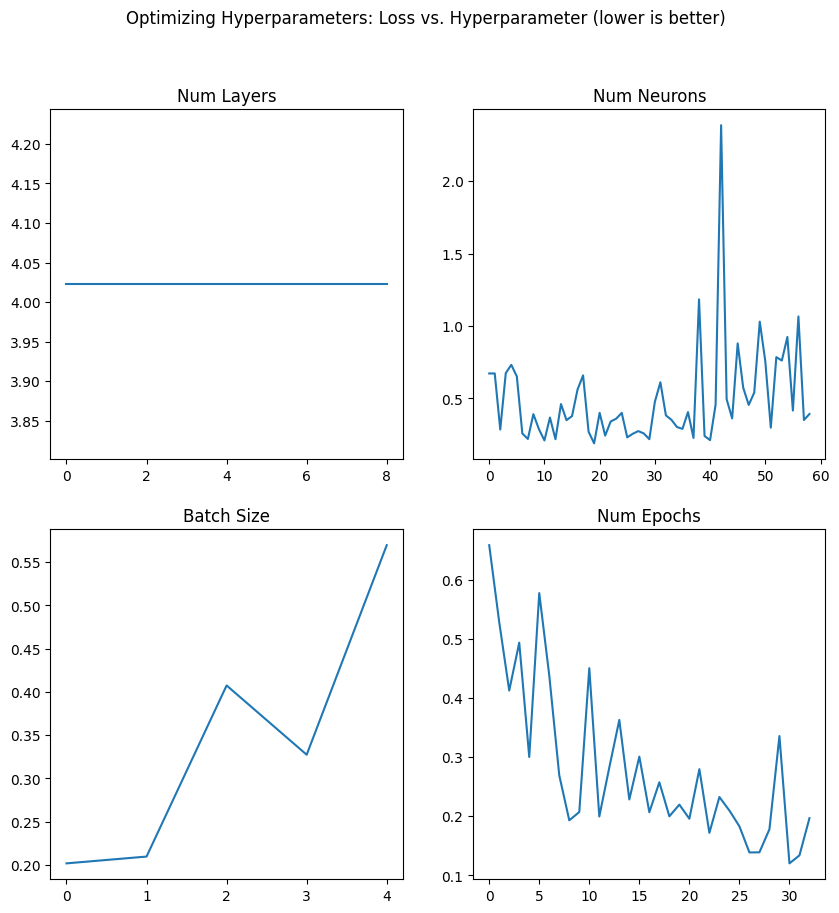

In [143]:
fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(10,10))
axs[0,0].plot(num_layers)
axs[0,0].set_title('Num Layers')
axs[0,1].plot(num_neurons)
axs[0,1].set_title('Num Neurons')
axs[1,0].plot(num_batch)
axs[1,0].set_title('Batch Size')
axs[1,1].plot(num_epochs)
axs[1,1].set_title('Num Epochs')

fig.suptitle('Optimizing Hyperparameters: Loss vs. Hyperparameter (lower is better)')
plt.show()


Most work as anticipated except number of layers where it had no influence in the final loss. Other than that the only other weird occurance was the number of neurons where the loss was super high.

In [144]:
# Setting up the tuned model
kf = KFold(n_splits=10, shuffle=True, random_state=4)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(9, activation='relu'),
    tf.keras.layers.Dense(9, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    model.fit(X_train, y_train, epochs=27,batch_size=2, verbose=0)
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    scores.append(accuracy_score(y_test, y_pred))



2/2 [==============================] - 0s 7ms/step


In [145]:
scores

[0.7192982456140351,
 0.6842105263157895,
 0.6491228070175439,
 0.6491228070175439,
 0.5614035087719298,
 0.7017543859649122,
 0.5614035087719298,
 0.6491228070175439,
 0.5087719298245614,
 0.5892857142857143]

<h1>Support Vector Machine</h1>
Support vector machine, usually abbreviated as SVM, creates a decision boundary that best separates all the points into 2 classes by creating a linear or a non-linear decision boundary based on the kernal fuction. One of its feature are the margins that surround the decision boundary. The model's hyperparameter C determines the penalty given for misclassified examples, which can affect the size of the margins. Small C values give a larger margin since the penalty is small, while large C values give a smaller margin since the penalty is larger.

Another feature are the kernal functions that maps data from one space to another, and also determines the shape of the hyperplane and decision boundary. Some functions include linear, polynomial, RBF, and Gaussian.

In [146]:

# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV
     

In [147]:
# Seperate data from labels, and put labels into its own set
svm_x = cc.drop(['Benign','Malignant'], axis = 1)
svm_y = cc['Malignant']

# Split by 80-20
X_train, X_test, y_train, y_test = train_test_split(svm_x, svm_y, test_size=0.2, random_state = 1)

# Fit on RBF kernel
svc = svm.SVC(kernel = 'rbf')
svc.fit(X_train, y_train)

# print prediction results
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        72
           1       1.00      0.74      0.85        42

    accuracy                           0.90       114
   macro avg       0.93      0.87      0.89       114
weighted avg       0.92      0.90      0.90       114



In [148]:
# Seperate data from labels, and put labels into its own set
svm_x = X_comp

# Split by 80-20
X_train, X_test, y_train, y_test = train_test_split(svm_x, svm_y, test_size=0.2, random_state = 1)

# Fit on RBF kernel
svc = svm.SVC(kernel = 'rbf')
svc.fit(X_train, y_train)

# print prediction results
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        72
           1       1.00      0.74      0.85        42

    accuracy                           0.90       114
   macro avg       0.93      0.87      0.89       114
weighted avg       0.92      0.90      0.90       114




Accuracy of the RBF kernal is 90%.


In [149]:
# Seperate data from labels, and put labels into its own set
svm_x = X

# Split by 80-20
X_train, X_test, y_train, y_test = train_test_split(svm_x, svm_y, test_size=0.2, random_state = 1)

# Fit on 2nd degree polynomial kernel
svc = svm.SVC(kernel = 'poly', degree = 2)
svc.fit(X_train, y_train)

# print prediction results
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        72
           1       1.00      0.71      0.83        42

    accuracy                           0.89       114
   macro avg       0.93      0.86      0.88       114
weighted avg       0.91      0.89      0.89       114



In [150]:
# Seperate data from labels, and put labels into its own set
svm_x = X_comp

# Split by 80-20
X_train, X_test, y_train, y_test = train_test_split(svm_x, svm_y, test_size=0.2, random_state = 1)

# Fit on 2nd degree polynomial kernel
svc = svm.SVC(kernel = 'poly', degree = 2)
svc.fit(X_train, y_train)

# print prediction results
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        72
           1       1.00      0.71      0.83        42

    accuracy                           0.89       114
   macro avg       0.93      0.86      0.88       114
weighted avg       0.91      0.89      0.89       114



The accuracy of the polynomial kernel is 89%.


In [151]:
# Seperate data from labels, and put labels into its own set
svm_x = X

# Split by 80-20
X_train, X_test, y_train, y_test = train_test_split(svm_x, svm_y, test_size=0.2, random_state = 1)

# Fit on linear kernel
svc = svm.SVC(kernel = 'linear')
svc.fit(X_train, y_train)

# print prediction results
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



In [152]:
# Seperate data from labels, and put labels into its own set
svm_x = X_comp

# Split by 80-20
X_train, X_test, y_train, y_test = train_test_split(svm_x, svm_y, test_size=0.2, random_state = 1)

# Fit on linear kernel
svc = svm.SVC(kernel = 'linear')
svc.fit(X_train, y_train)

# print prediction results
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



Accuracy of the linear kernal is 96%. Let's see if we can tune the hyperparameter C to the RBF kernel function.



In [153]:

param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(svc, param_grid, refit = True, verbose = 3)

grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.626 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [154]:

# Print best parameter
print(grid.best_params_)
  
# Show accuracy 
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        72
           1       0.93      0.88      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



For the RBF kernel function, C = 100 was determined to be the best hyperparameter, when applied to the RBF SVM the accuracy is 93%.